## **Câu 6: Association Rules – BAKERY (1.0 điểm)**
Use dataset 75000 (select one file in this folder that is suitable for you) to build the 
model to identify sets of items that are frequently bought together (please use Flavor 
and Food name (in goods.csv) instead of Id).
Read more information here:
Dataset: http://users.csc.calpoly.edu/~dekhtyar/466-Spring2018/labs/lab01.html


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
import pyspark
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml.feature import CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from scipy import stats
from datetime import datetime
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer, OneHotEncoder, Bucketizer, VectorAssembler, StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import round

from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when

from pyspark.ml.linalg import Vectors


In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.fpm import FPGrowth

from pyspark.ml.classification import LogisticRegressionModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import iqr
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import iqr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky


In [8]:
from pyspark import SparkContext
sc = SparkContext()


In [9]:
spark = SparkSession(sc)

In [10]:
df = spark.read.csv('data/75000/75000i.csv', header = False, inferSchema = True)

### **Phân tích khai phá dữ liệu và tiền xử lý (EDA & Preprocessing)**

In [11]:
df.show(5)

+---+---+---+
|_c0|_c1|_c2|
+---+---+---+
|  1|  1| 21|
|  1|  5| 11|
|  2|  1|  7|
|  2|  3| 11|
|  2|  4| 37|
+---+---+---+
only showing top 5 rows



In [12]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: integer (nullable = true)



In [13]:
df.describe().show()

+-------+------------------+------------------+------------------+
|summary|               _c0|               _c1|               _c2|
+-------+------------------+------------------+------------------+
|  count|            266209|            266209|            266209|
|   mean|37506.447599442545|3.0004620429812667| 24.28233455668291|
| stddev|21665.459090368462|1.4135532622940965|14.771318203617861|
|    min|                 1|                 1|                 0|
|    max|             75000|                 5|                49|
+-------+------------------+------------------+------------------+



### **Clean Data**

### **Check missing data**

In [14]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
_c0,0
_c1,0
_c2,0


In [15]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
_c0,0
_c1,0
_c2,0


In [16]:
'''
dataset ko có null, ko có nan
'''

'\ndataset ko có null, ko có nan\n'

### **Check duplicates**

In [18]:
total = df.count()
distinct = df.distinct().count()

print('df', 'có', total, 'records')
print('df', 'có', distinct, 'distinct records')
if total > distinct:
    print('df', 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
else:
    print('df', 'ko có duplicate records')

df có 266209 records
df có 266209 distinct records
df ko có duplicate records


In [20]:
# đổi tên cho dễ nhớ
df = df.withColumnRenamed('_c0', 'receipt_id').withColumnRenamed('_c1', 'quantity').withColumnRenamed('_c2', 'product_id')

In [21]:
df.describe().show()

+-------+------------------+------------------+------------------+
|summary|        receipt_id|          quantity|        product_id|
+-------+------------------+------------------+------------------+
|  count|            266209|            266209|            266209|
|   mean|37506.447599442545|3.0004620429812667| 24.28233455668291|
| stddev|21665.459090368462|1.4135532622940965|14.771318203617861|
|    min|                 1|                 1|                 0|
|    max|             75000|                 5|                49|
+-------+------------------+------------------+------------------+



### **Phân tích tổng quan các biến**
Từ bảng thống kê describe() và mô tả dữ liệu, ta thấy:
- receipt_id, product_id: identification variable
- quantity: categorical variable

In [22]:
def categorical_univariate_variable(f):
    print("1\ Mật độ phân phối: \n", f.value_counts())
    print("2\ Số giá trị NaN: \n", f.isnull().sum())
    print("\n\n3\ Tỉ lệ mật độ phân phối:\n", f.value_counts() / len(f))
    f.value_counts().plot.bar()
    plt.show()

In [23]:
df_pd = df.toPandas()

1\ Mật độ phân phối: 
 3    53463
5    53271
2    53267
1    53120
4    53088
Name: quantity, dtype: int64
2\ Số giá trị NaN: 
 0


3\ Tỉ lệ mật độ phân phối:
 3    0.200831
5    0.200110
2    0.200095
1    0.199542
4    0.199422
Name: quantity, dtype: float64


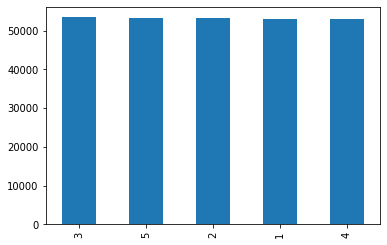

In [24]:
categorical_univariate_variable(df_pd.quantity)

=> tỉ lệ phân phối giữa các giá trị khá đều

In [30]:
df.createOrReplaceTempView('order_product_data')

In [31]:
products = spark.sql('SELECT DISTINCT product_id FROM order_product_data')


In [32]:
products.count()

50

### **Modeling and Evaluating**

### **1. Build model với product_id**

In [33]:
rawData = spark.sql('select * from order_product_data')
baskets = rawData.groupBy('receipt_id').agg(collect_set('product_id')\
                                         .alias('items'))
baskets.createOrReplaceTempView('baskets')

In [34]:
baskets.show(10, truncate = False)


+----------+----------------------+
|receipt_id|items                 |
+----------+----------------------+
|148       |[33, 27, 9, 46, 28, 4]|
|463       |[17, 14]              |
|471       |[9, 37, 34, 20]       |
|496       |[15, 6, 47, 26]       |
|833       |[12, 5, 21]           |
|1088      |[27, 35, 3, 18, 40]   |
|1238      |[19, 32, 18]          |
|1342      |[49, 17, 8]           |
|1580      |[12, 31, 36]          |
|1591      |[1, 19]               |
+----------+----------------------+
only showing top 10 rows



MinSupport và minConfidence sẽ được đặt ở mức thấp nhất do lượng giao dịch quá lớn

In [37]:
fpgrowth = FPGrowth(itemsCol = 'items', minSupport = 0.003, minConfidence = 0.003)
model = fpgrowth.fit(baskets)

In [38]:
model.freqItemsets.show()

+--------+----+
|   items|freq|
+--------+----+
|     [7]|8193|
|    [45]|7700|
| [45, 7]|2367|
|    [28]|7556|
|[28, 45]| 387|
| [28, 7]| 383|
|    [18]|6987|
|[18, 28]| 393|
|[18, 45]| 318|
| [18, 7]| 321|
|     [4]|6948|
| [4, 28]| 465|
| [4, 45]| 372|
| [4, 18]| 402|
|  [4, 7]| 378|
|    [35]|6943|
|[35, 28]| 381|
| [35, 4]| 388|
|[35, 45]| 309|
|[35, 18]|3982|
+--------+----+
only showing top 20 rows



In [39]:
mostPopularItemInBasket = model.transform(baskets)

In [40]:
mostPopularItemInBasket.show(5, truncate =  False)

+----------+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|receipt_id|items                 |prediction                                                                                                                                                                            |
+----------+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|148       |[33, 27, 9, 46, 28, 4]|[35, 22, 45, 18, 42, 7, 14, 32, 1, 0, 16, 5, 3, 47, 37, 11, 15, 19, 44, 2, 17, 40, 12, 24, 49, 29, 41, 36, 23, 31, 43, 48, 39, 20, 21, 34, 30, 8, 38, 26, 6, 13, 10, 25]              |
|463       |[17, 14]              |[27, 28, 35, 4, 22, 45, 18, 42, 7, 32, 1, 0, 46, 16, 9, 5, 33, 3, 47, 37, 11, 15, 19, 44,

Kết quả đưa ra rất nhiều sản phẩm được đề xuất cho mỗi giao dịch

### **1. Build model với product_name**

In [42]:
product = spark.read.csv('data/75000/goods.csv', header = True, inferSchema = True)

In [43]:
product.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Flavor: string (nullable = true)
 |-- Food: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Type: string (nullable = true)



In [44]:
product.show(3, truncate = False)

+---+-----------+------+-----+------+
|Id |Flavor     |Food  |Price|Type  |
+---+-----------+------+-----+------+
|0  |'Chocolate'|'Cake'|8.95 |'Food'|
|1  |'Lemon'    |'Cake'|8.95 |'Food'|
|2  |'Casino'   |'Cake'|15.95|'Food'|
+---+-----------+------+-----+------+
only showing top 3 rows



In [45]:
product = product.withColumn('Flavor', regexp_replace('Flavor', "\'", ""))
product = product.withColumn('Food', regexp_replace('Food', "\'", ""))

In [46]:
product.show(10)

+---+----------+------+-----+------+
| Id|    Flavor|  Food|Price|  Type|
+---+----------+------+-----+------+
|  0| Chocolate|  Cake| 8.95|'Food'|
|  1|     Lemon|  Cake| 8.95|'Food'|
|  2|    Casino|  Cake|15.95|'Food'|
|  3|     Opera|  Cake|15.95|'Food'|
|  4|Strawberry|  Cake|11.95|'Food'|
|  5|   Truffle|  Cake|15.95|'Food'|
|  6| Chocolate|Eclair| 3.25|'Food'|
|  7|    Coffee|Eclair|  3.5|'Food'|
|  8|   Vanilla|Eclair| 3.25|'Food'|
|  9|  Napoleon|  Cake|13.49|'Food'|
+---+----------+------+-----+------+
only showing top 10 rows



Chúng ta  sẽ sử dụng Flavor và Food thay vì chọn 1 trong 2 vì Flavor và Food có giá trị trùng lặp riêng. 
Ví dụ: Flavor có 2 Chocolate trong column của Flavor và food có rất nhiều cake...

=> Lựa chọn cần thiết là kết hợp 2 features: Chocolate Cake và Chocolate Eclair => nó sẽ không trùng lặp nữa.

In [47]:
product_data = product.select(concat_ws(' ',product.Flavor,product.Food).alias('product_name'),'Id', 'Flavor', 'Food', 'Price', 'Type')

In [48]:
product_data.show(5)

+---------------+---+----------+----+-----+------+
|   product_name| Id|    Flavor|Food|Price|  Type|
+---------------+---+----------+----+-----+------+
| Chocolate Cake|  0| Chocolate|Cake| 8.95|'Food'|
|     Lemon Cake|  1|     Lemon|Cake| 8.95|'Food'|
|    Casino Cake|  2|    Casino|Cake|15.95|'Food'|
|     Opera Cake|  3|     Opera|Cake|15.95|'Food'|
|Strawberry Cake|  4|Strawberry|Cake|11.95|'Food'|
+---------------+---+----------+----+-----+------+
only showing top 5 rows



In [49]:
product_data.createOrReplaceTempView('products')

In [50]:
rawData1 = spark.sql('''select p.product_name, o.receipt_id from products p inner join order_product_data o
                        where o.product_id = p.id''')
baskets1 = rawData1.groupBy('receipt_id').agg(collect_set('product_name')\
                                         .alias('items'))

In [51]:
baskets1.head(3)

[Row(receipt_id=148, items=['Tuile Cookie', 'Strawberry Cake', 'Napoleon Cake', 'Chocolate Coffee', 'Cheese Croissant', 'Marzipan Cookie']),
 Row(receipt_id=463, items=['Berry Tart', 'Chocolate Tart']),
 Row(receipt_id=471, items=['Almond Twist', 'Chocolate Croissant', 'Pecan Tart', 'Napoleon Cake'])]

In [52]:
fpgrowth1 = FPGrowth(itemsCol = 'items', minSupport = 0.003, minConfidence = 0.003)
model1 = fpgrowth.fit(baskets1)

In [53]:
model1.freqItemsets.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|     [Coffee Eclair]|8193|
|        [Hot Coffee]|7700|
|[Hot Coffee, Coff...|2367|
|      [Tuile Cookie]|7556|
|[Tuile Cookie, Ho...| 387|
|[Tuile Cookie, Co...| 383|
|       [Cherry Tart]|6987|
|[Cherry Tart, Tui...| 393|
|[Cherry Tart, Hot...| 318|
|[Cherry Tart, Cof...| 321|
|   [Strawberry Cake]|6948|
|[Strawberry Cake,...| 465|
|[Strawberry Cake,...| 372|
|[Strawberry Cake,...| 402|
|[Strawberry Cake,...| 378|
|    [Apricot Danish]|6943|
|[Apricot Danish, ...| 381|
|[Apricot Danish, ...| 388|
|[Apricot Danish, ...| 309|
|[Apricot Danish, ...|3982|
+--------------------+----+
only showing top 20 rows



In [54]:
mostPopularItemInBasket1 = model1.transform(baskets1)

In [55]:
mostPopularItemInBasket1.show()

+----------+--------------------+--------------------+
|receipt_id|               items|          prediction|
+----------+--------------------+--------------------+
|       148|[Tuile Cookie, St...|[Hot Coffee, Cher...|
|       463|[Berry Tart, Choc...|[Lemon Tart, Marz...|
|       471|[Almond Twist, Ch...|[Marzipan Cookie,...|
|       496|[Vanilla Meringue...|[Lemon Tart, Marz...|
|       833|[Ganache Cookie, ...|[Lemon Tart, Chee...|
|      1088|[Cherry Tart, Ope...|[Cheese Croissant...|
|      1238|[Cherry Tart, Apr...|[Marzipan Cookie,...|
|      1342|[Single Espresso,...|[Lemon Tart, Marz...|
|      1580|[Apple Croissant,...|[Lemon Tart, Chee...|
|      1591|[Lemon Cake, Lemo...|[Marzipan Cookie,...|
|      1645|[Coffee Eclair, B...|[Hot Coffee, Tuil...|
|      1829|[Coffee Eclair, A...|[Lemon Tart, Rasp...|
|      1959|[Cherry Tart, Lem...|[Tuile Cookie, Ho...|
|      2122|[Truffle Cake, Go...|[Tuile Cookie, Ap...|
|      2142|[Bottled Water, B...|[Lemon Tart, Chee...|
|      236

In [56]:
mostPopularItemInBasket1.printSchema()

root
 |-- receipt_id: integer (nullable = true)
 |-- items: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- prediction: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [57]:
mostPopularItemInBasket1.createOrReplaceTempView('popular_items')
DF_cast = mostPopularItemInBasket1.select('receipt_id', mostPopularItemInBasket1.items.cast(StringType()),
                                         mostPopularItemInBasket1.prediction.cast(StringType()))
DF_cast.printSchema()

root
 |-- receipt_id: integer (nullable = true)
 |-- items: string (nullable = false)
 |-- prediction: string (nullable = true)



=> Kết quả đã đưa ra rất nhiều khuyến nghị cho mọi sản phẩm.

In [58]:
DF_cast.head(3)

[Row(receipt_id=148, items='[Tuile Cookie, Strawberry Cake, Napoleon Cake, Chocolate Coffee, Cheese Croissant, Marzipan Cookie]', prediction='[Hot Coffee, Cherry Tart, Coffee Eclair, Apricot Danish, Orange Juice, Gongolais Cookie, Berry Tart, Apricot Croissant, Lemon Cake, Chocolate Cake, Blueberry Tart, Truffle Cake, Opera Cake, Vanilla Frappuccino, Almond Twist, Apple Pie, Blackberry Tart, Lemon Tart, Bottled Water, Casino Cake, Chocolate Tart, Lemon Lemonade, Apple Tart, Lemon Cookie, Single Espresso, Walnut Cookie, Raspberry Lemonade, Apple Danish, Raspberry Cookie, Apple Croissant, Green Tea, Cherry Soda, Blueberry Danish, Pecan Tart, Ganache Cookie, Chocolate Croissant, Almond Croissant, Vanilla Eclair, Almond Bear Claw, Vanilla Meringue, Chocolate Eclair, Apricot Tart, Almond Tart, Chocolate Meringue]'),
 Row(receipt_id=463, items='[Berry Tart, Chocolate Tart]', prediction='[Lemon Tart, Marzipan Cookie, Cheese Croissant, Lemon Cake, Tuile Cookie, Almond Twist, Apricot Danish, Bl

In [59]:
# lưu lại nàoo
DF_cast.write.csv('Exercise6/recommended_goods.csv')